# Should this loan be approved or not?

### Import Data & Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
SBA = pd.read_csv("../data/SBA_cleaned.csv", na_values='nan', index_col=None)
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,2.0,N,Y,P I F,0.80,0
1,72,60,2,2.0,N,Y,P I F,0.80,0
2,62,180,7,1.0,N,N,P I F,0.75,0
3,31-33,120,19,1.0,N,N,P I F,0.75,0
4,81,84,1,2.0,N,Y,P I F,0.80,0


### Preprocessing

#### Handle outliers

"According to the SBA, a small businesses have a maximum of anywhere between 250 and 1500 employees— all depending on the specific industry the business is in. Additionally, businesses have revenue limits that they must not exceed if they want to qualify for SBA financing. In general, companies with more than 1500 employees are not eligible for SBA loans." 

References: https://www.sba7a.loans/sba-7a-loans-small-business-blog/small-business-definition

In [4]:
SBA[SBA['NoEmp'] > 1500].value_counts().sum() # 72, a very small portion of the data, so we can drop these rows
SBA = SBA[SBA['NoEmp'] < 1500]

#### Encode categorical variables

In [5]:
# Label encoding for the NewExist, RevLineCr, LowDoc, MIS_Status columns
label_encoder = LabelEncoder()

# Apply label encoding to the 'NewExist' column
SBA['NewExist'] = label_encoder.fit_transform(SBA['NewExist']) # 0: Existing business, 1: New business

# Apply label encoding to the 'RevLineCr' column
SBA['RevLineCr'] = label_encoder.fit_transform(SBA['RevLineCr']) # 0: N, 1: Y

# Apply label encoding to the 'LowDoc' column
SBA['LowDoc'] = label_encoder.fit_transform(SBA['LowDoc']) # 0: N, 1: Y

# Apply label encoding to the 'MIS_Status' column
SBA['MIS_Status'] = label_encoder.fit_transform(SBA['MIS_Status']) # 0: CHGOFF, 1: P I F

In [6]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,0,1,1,0.80,0
1,72,60,2,1,0,1,1,0.80,0
2,62,180,7,0,0,0,1,0.75,0
3,31-33,120,19,0,0,0,1,0.75,0
4,81,84,1,1,0,1,1,0.80,0


#### Handle `Term` and `NoEmp`

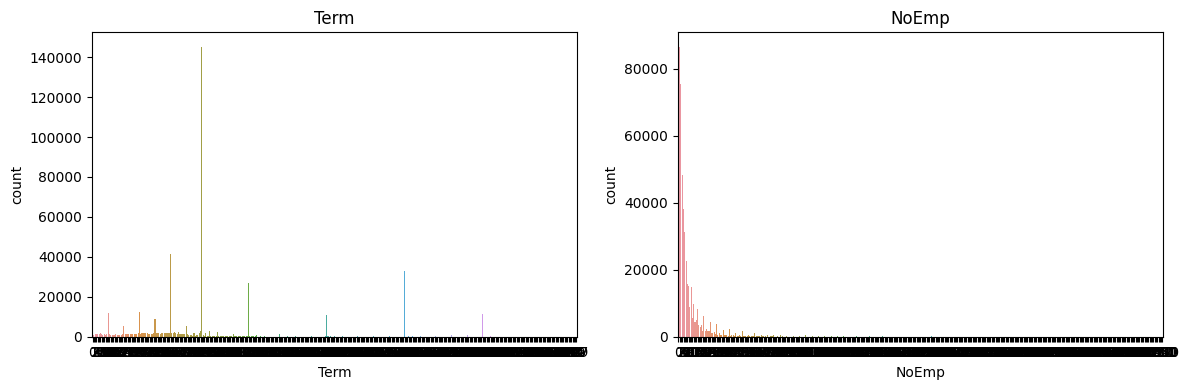

In [7]:
# Visualize the Term and NoEmp columns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=SBA, x='Term')
plt.title('Term')

plt.subplot(1, 2, 2)
sns.countplot(data=SBA, x='NoEmp')
plt.title('NoEmp')

plt.tight_layout()
plt.show()

In [8]:
# minmax = MinMaxScaler()
# SBAnorm = pd.DataFrame(minmax.fit_transform(SBA[['Term', 'NoEmp']]), columns=['Term', 'NoEmp'])
# SBA.drop(['Term', 'NoEmp'], axis=1, inplace=True)
# SBA = pd.concat([SBA, SBAnorm], axis=1)

# After modelling, we found that the minmax scaler did reduce the model performance, so we will not use it.

#### Handle `NAISC` column

In [9]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,0,1,1,0.80,0
1,72,60,2,1,0,1,1,0.80,0
2,62,180,7,0,0,0,1,0.75,0
3,31-33,120,19,0,0,0,1,0.75,0
4,81,84,1,1,0,1,1,0.80,0


In [10]:
NAICScol = pd.get_dummies(SBA['NAICS'], prefix='NAICS')
NAICScol = NAICScol.replace({True: 1, False: 0})

In [11]:
SBA.drop('NAICS', axis=1, inplace=True)
SBA = pd.concat([SBA, NAICScol], axis=1)

In [12]:
SBA['MIS_Status'].unique()

array([1, 0])

In [13]:
SBA.shape

(459432, 28)

In [14]:
SBA.head()

,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate,NAICS_11,NAICS_21,NAICS_22,NAICS_23,NAICS_31-33,NAICS_42,NAICS_44-45,NAICS_48-49,NAICS_51,NAICS_52,NAICS_53,NAICS_54,NAICS_55,NAICS_56,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92
0,84,4,1,0,1,1,0.80,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,60,2,1,0,1,1,0.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,180,7,0,0,0,1,0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,120,19,0,0,0,1,0.75,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,84,1,1,0,1,1,0.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Set Up Before Modelling

In [15]:
SBA['MIS_Status'].value_counts() 
# About 4:1 before and after cleaning, I think we can use this ratio because in real life, this can happen.

MIS_Status
1    360892
0     98540
Name: count, dtype: int64

In [16]:
SBA_1 = SBA[SBA['MIS_Status'] == 1].sample(n=40000, random_state=4)
SBA_0 = SBA[SBA['MIS_Status'] == 0].sample(n=10000, random_state=4)
data = pd.concat([SBA_1, SBA_0], axis=0)

In [17]:
y = data.MIS_Status
X = data.drop(['MIS_Status'], axis=1)

In [18]:
X = X.to_numpy()

In [19]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=4)

### Modelling

#### Get F1_score for some models
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. KNN

Objective : Find the best F1_Score with K-Fold Cross Validation

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
algorithm = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier]
algo_name = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier']
F1Score = []

for item in algorithm:
  model = item()
  F1Scores = cross_val_score(model,X_train,y_train,cv=5,scoring='f1').mean()
  F1Score.append(F1Scores)

results = pd.DataFrame({
    'Algorithm' : algo_name,
    'F1 Score' : F1Score,
})

results

,Algorithm,F1 Score
0,LogisticRegression,0.893231
1,DecisionTreeClassifier,0.938714
2,RandomForestClassifier,0.942702
3,KNeighborsClassifier,0.945205


#### KNN

In [21]:
knn = KNeighborsClassifier()

In [22]:
param_random_knn = {
    'algorithm' : ['auto','ball_tree', 'kd_tree','brute'],
    'n_neighbors' : [3,5,7,9,11],
    'leaf_size' : [10, 30] 
}
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_random_knn,cv=5, scoring='roc_auc', n_jobs=-1)
random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 30],
                                        'n_neighbors': [3, 5, 7, 9, 11]},
                   scoring='roc_auc')

In [23]:
random_search_knn.best_params_

{'n_neighbors': 11, 'leaf_size': 30, 'algorithm': 'ball_tree'}

In [24]:
knn_random = random_search_knn.best_estimator_

In [25]:
knn_random_pred = knn_random.predict(X_test)
knn_random_proba = knn_random.predict_proba(X_test)

In [26]:
print(classification_report(y_test, knn_random_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2500
           1       0.93      0.96      0.95     10000

    accuracy                           0.91     12500
   macro avg       0.87      0.84      0.86     12500
weighted avg       0.91      0.91      0.91     12500



In [27]:
tnknn, fpknn, fnknn, tpknn = confusion_matrix(y_test, knn_random_pred).ravel()
print(confusion_matrix(y_test, knn_random_pred))

[[1821  679]
 [ 427 9573]]


#### Random Forest

In [28]:
rfc = RandomForestClassifier()

In [29]:
param_grid_rfc = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,15,20],
    'min_samples_split': [2,5,10,20],
    'n_estimators': [100,200]
}
grid_search_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [30]:
grid_search_rfc.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 10,
 'n_estimators': 200}

In [31]:
rfc_grid = grid_search_rfc.best_estimator_

In [32]:
rfc_grid_pred = rfc_grid.predict(X_test)
rfc_grid_proba = rfc_grid.predict_proba(X_test)

In [33]:
print(classification_report(y_test, rfc_grid_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      2500
           1       0.94      0.96      0.95     10000

    accuracy                           0.92     12500
   macro avg       0.88      0.85      0.87     12500
weighted avg       0.92      0.92      0.92     12500



In [34]:
tnrfc, fprfc, fnrfc, tprfc = confusion_matrix(y_test, rfc_grid_pred).ravel()
print(confusion_matrix(y_test, rfc_grid_pred))

[[1872  628]
 [ 401 9599]]


#### Decision Tree

In [35]:
dtc = DecisionTreeClassifier()

In [36]:
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,15,20],
    'min_samples_split': [2,5,10,20],
}
grid_search_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid_dtc, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='roc_auc')

In [37]:
grid_search_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 20}

In [38]:
dtc_grid = grid_search_dtc.best_estimator_

In [39]:
dtc_grid_pred = dtc_grid.predict(X_test)
dtc_grid_proba = dtc_grid.predict_proba(X_test)

In [40]:
print(classification_report(y_test, dtc_grid_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2500
           1       0.96      0.95      0.96     10000

    accuracy                           0.93     12500
   macro avg       0.89      0.90      0.89     12500
weighted avg       0.93      0.93      0.93     12500



In [41]:
tndtc, fpdtc, fndtc, tpdtc = confusion_matrix(y_test, dtc_grid_pred).ravel()
print(confusion_matrix(y_test, dtc_grid_pred))

[[2144  356]
 [ 510 9490]]


### Evaluation

#### KNN

In [42]:
knn_prob = knn_random.predict_proba(X_test)
probknn = knn_prob[:,1]
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test, probknn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

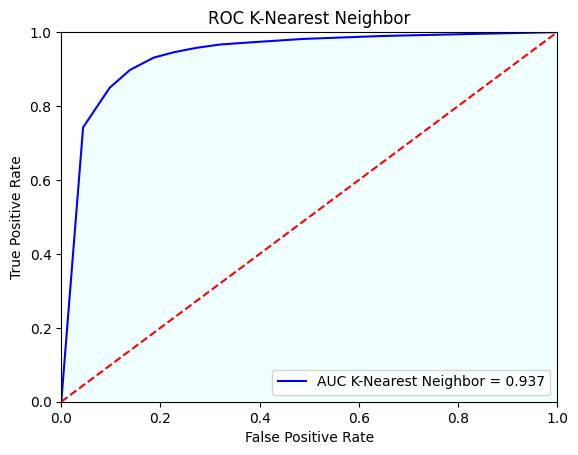

In [43]:
plt.title('ROC K-Nearest Neighbor')
plt.plot(fpr_knn, tpr_knn, 'blue', label='AUC K-Nearest Neighbor = {}'.format(round(roc_auc_knn,3)))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_knn, tpr_knn, 0, facecolor='azure', alpha=1)
plt.legend(loc='lower right')

#### Random Forest

In [44]:
rfc_prob = rfc_grid.predict_proba(X_test)
probrfc = rfc_prob[:,1]
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test, probrfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

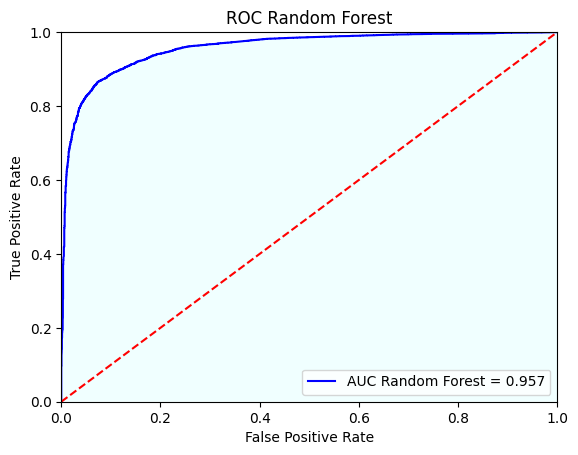

In [45]:
plt.title('ROC Random Forest')
plt.plot(fpr_rfc, tpr_rfc, 'blue', label='AUC Random Forest = {}'.format(round(roc_auc_rfc,3)))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_rfc, tpr_rfc, 0, facecolor='azure', alpha=1)
plt.legend(loc='lower right')

#### Decision Tree

In [46]:
dtc_prob = dtc_grid.predict_proba(X_test)
probdtc = dtc_prob[:,1]
fpr_dtc, tpr_dtc, threshold_dtc = roc_curve(y_test, probdtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

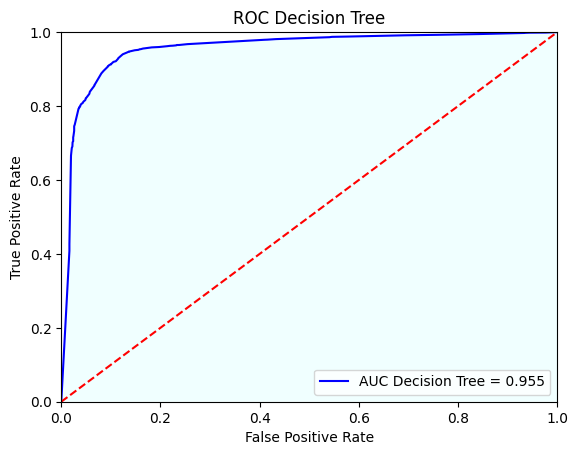

In [47]:
plt.title('ROC Decision Tree')
plt.plot(fpr_dtc, tpr_dtc, 'blue', label='AUC Decision Tree = {}'.format(round(roc_auc_dtc,3)))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_dtc, tpr_dtc, 0, facecolor='azure', alpha=1)
plt.legend(loc='lower right')

### Compare the models

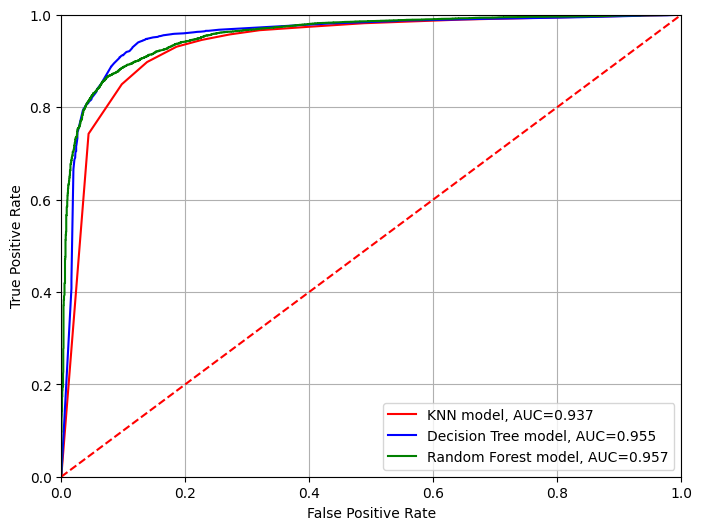

In [49]:
plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr_knn, tpr_knn, label="KNN model, AUC=" + str(round(roc_auc_knn,3)), color='red')
plt.plot(fpr_dtc, tpr_dtc, label="Decision Tree model, AUC=" + str(round(roc_auc_dtc,3)), color='blue')
plt.plot(fpr_rfc, tpr_rfc, label="Random Forest model, AUC=" + str(round(roc_auc_rfc,3)), color='green')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.show()